# ML task on Used Cars dataset
**Target:**
Predict how many days `duration_listed` it will take to sell a car on a web platform.

<img src="cars.jpg" width=1256 height=353 />

In [1]:
from pyspark.sql import SparkSession

In [2]:
appName = "ML pipline"
master = "local[4]"

spark = SparkSession.builder.master(master).appName(appName).getOrCreate()

21/12/13 09:28:58 WARN Utils: Your hostname, Dmitrijs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.16.104.9 instead (on interface en0)
21/12/13 09:28:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/13 09:29:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

# 0. Reading Data

In [4]:
df_cars = spark.read.csv('cars.csv', header='True', inferSchema=True)
TARGET = 'duration_listed'

In [5]:
df_cars = df_cars.dropna()

In [6]:
df_cars.printSchema()

root
 |-- manufacturer_name: string (nullable = true)
 |-- model_name: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- odometer_value: integer (nullable = true)
 |-- year_produced: integer (nullable = true)
 |-- engine_capacity: double (nullable = true)
 |-- body_type: string (nullable = true)
 |-- price_usd: double (nullable = true)
 |-- location_region: string (nullable = true)
 |-- number_of_photos: integer (nullable = true)
 |-- up_counter: integer (nullable = true)
 |-- duration_listed: integer (nullable = true)



### Separating different data types

In [7]:
str_cols = [item[0] for item in df_cars.dtypes if item[1].startswith('string')]

float_cols = [item[0] for item in df_cars.dtypes if item[1].startswith('double')]

int_cols = [item[0] for item in df_cars.dtypes if item[1].startswith('int')]

bool_cols = [item[0] for item in df_cars.dtypes if item[1].startswith('boolean')]

# 1. Splitting the data into train and test

### 1.1 Simple splitting

In [8]:
# Split the data into train and test sets
train, test = df_cars.randomSplit([.75, .25], seed=1234)

In [9]:
print(f'Train size: {train.count()}\nTest size:  {test.count()}')

Train size: 28854
Test size:  9667


**Note**

Stratified split need to be done by hands

### 1.2 Stratified splitting

In [10]:
df_cars.groupby('transmission').count().show()

+------------+-----+
|transmission|count|
+------------+-----+
|   automatic|12888|
|  mechanical|25633|
+------------+-----+



In [11]:
zeros = df_cars.filter("transmission = 'automatic'")
ones = df_cars.filter("transmission = 'mechanical'")
# split datasets into training and testing
train0, test0 = zeros.randomSplit([.75, .25], seed=1234)
train1, test1 = ones.randomSplit([.75, .25], seed=1234)
# stack datasets back together
train = train0.union(train1)
test = test0.union(test1)

In [12]:
train.count(), test.count()

(28900, 9621)

# 2. Encoding Categorical variables

### 2.1 Label encoding (string indexing)

In [13]:
from pyspark.ml.feature import StringIndexer

In [14]:
str_cols_ind =[col +'_ind' for col in str_cols]

str_indexer = StringIndexer(inputCols=str_cols, outputCols=str_cols_ind)

train = str_indexer.fit(train).transform(train)

In [15]:
train.select('manufacturer_name', 'manufacturer_name_ind').distinct().sort('manufacturer_name_ind').show(5)

+-----------------+---------------------+
|manufacturer_name|manufacturer_name_ind|
+-----------------+---------------------+
|       Volkswagen|                  0.0|
|             Opel|                  1.0|
|              BMW|                  2.0|
|             Ford|                  3.0|
|             Audi|                  4.0|
+-----------------+---------------------+
only showing top 5 rows



### 2.2 One hot encoding

In [16]:
from pyspark.ml.feature import OneHotEncoder

In [17]:
# Create a OneHotEncoder

str_dummys = [col + '_dummy' for col in str_cols]

onehot = OneHotEncoder(inputCols=str_cols_ind, outputCols=str_dummys)

In [18]:
train = onehot.fit(train).transform(train)

In [19]:
train.select('manufacturer_name',
             'manufacturer_name_ind',
             'manufacturer_name_dummy')\
            .distinct()\
            .sort('manufacturer_name_ind')\
            .show()

+-----------------+---------------------+-----------------------+
|manufacturer_name|manufacturer_name_ind|manufacturer_name_dummy|
+-----------------+---------------------+-----------------------+
|       Volkswagen|                  0.0|         (54,[0],[1.0])|
|             Opel|                  1.0|         (54,[1],[1.0])|
|              BMW|                  2.0|         (54,[2],[1.0])|
|             Ford|                  3.0|         (54,[3],[1.0])|
|             Audi|                  4.0|         (54,[4],[1.0])|
|          Renault|                  5.0|         (54,[5],[1.0])|
|    Mercedes-Benz|                  6.0|         (54,[6],[1.0])|
|          Peugeot|                  7.0|         (54,[7],[1.0])|
|          Citroen|                  8.0|         (54,[8],[1.0])|
|           Nissan|                  9.0|         (54,[9],[1.0])|
|            Mazda|                 10.0|        (54,[10],[1.0])|
|           Toyota|                 11.0|        (54,[11],[1.0])|
|         

### `Note` Dense vs Sparse vectors

In [21]:
from pyspark.ml.linalg import SparseVector, DenseVector

DenseVector([1, 0, 0, 0, 0, 0, 7, 0, 0])

DenseVector([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0])

In [22]:
SparseVector(9, [0, 6], [1, 7])

SparseVector(9, {0: 1.0, 6: 7.0})

# 4. Vectorizing predictors

In [23]:
from pyspark.ml.feature import VectorAssembler

In [24]:
train = train.select(int_cols + float_cols + str_dummys)

vec_assembler = VectorAssembler(inputCols=train.columns, outputCol='features')

train = vec_assembler.transform(train)

train.select('features').show()

+--------------------+
|            features|
+--------------------+
|(1150,[0,1,2,3,4,...|
|(1150,[0,1,2,3,4,...|
|(1150,[0,1,2,3,4,...|
|(1150,[0,1,2,3,4,...|
|(1150,[0,1,2,3,4,...|
|(1150,[0,1,2,3,4,...|
|(1150,[0,1,2,3,4,...|
|(1150,[0,1,2,3,4,...|
|(1150,[0,1,2,3,4,...|
|(1150,[0,1,2,3,4,...|
|(1150,[0,1,2,3,4,...|
|(1150,[0,1,2,3,4,...|
|(1150,[0,1,2,3,4,...|
|(1150,[0,1,2,3,4,...|
|(1150,[0,1,2,3,4,...|
|(1150,[0,1,2,3,4,...|
|(1150,[0,1,2,3,4,...|
|(1150,[0,1,2,3,4,...|
|(1150,[0,1,2,3,4,...|
|(1150,[0,1,2,3,4,...|
+--------------------+
only showing top 20 rows



# 5. Baseline model

In [25]:
import pyspark.ml

In [28]:
dir(pyspark.ml.regression)
dir(pyspark.ml.regression)

['ABCMeta',
 'AFTSurvivalRegression',
 'AFTSurvivalRegressionModel',
 'DataFrame',
 'DecisionTreeRegressionModel',
 'DecisionTreeRegressor',
 'FMRegressionModel',
 'FMRegressor',
 'GBTRegressionModel',
 'GBTRegressor',
 'GeneralJavaMLWritable',
 'GeneralizedLinearRegression',
 'GeneralizedLinearRegressionModel',
 'GeneralizedLinearRegressionSummary',
 'GeneralizedLinearRegressionTrainingSummary',
 'HasAggregationDepth',
 'HasElasticNetParam',
 'HasFeaturesCol',
 'HasFitIntercept',
 'HasLabelCol',
 'HasLoss',
 'HasMaxBlockSizeInMB',
 'HasMaxIter',
 'HasPredictionCol',
 'HasRegParam',
 'HasSeed',
 'HasSolver',
 'HasStandardization',
 'HasStepSize',
 'HasTol',
 'HasTrainingSummary',
 'HasVarianceCol',
 'HasWeightCol',
 'IsotonicRegression',
 'IsotonicRegressionModel',
 'JavaEstimator',
 'JavaMLReadable',
 'JavaMLWritable',
 'JavaModel',
 'JavaPredictionModel',
 'JavaPredictor',
 'JavaWrapper',
 'LinearRegression',
 'LinearRegressionModel',
 'LinearRegressionSummary',
 'LinearRegressionTra

In [29]:
from pyspark.ml.regression import LinearRegression

In [30]:
reg = LinearRegression(labelCol=TARGET, featuresCol='features')

In [31]:
reg = reg.fit(train)

21/12/13 09:34:29 WARN Instrumentation: [c33069d2] regParam is zero, which might cause numerical instability and overfitting.
21/12/13 09:34:32 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
21/12/13 09:34:33 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
21/12/13 09:34:34 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
21/12/13 09:34:35 WARN Instrumentation: [c33069d2] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
21/12/13 09:34:36 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/12/13 09:34:36 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [34]:
predictions = reg.transform(train)

In [35]:
predictions.select('prediction', TARGET).show()

+------------------+---------------+
|        prediction|duration_listed|
+------------------+---------------+
|171.99966937750236|            172|
|152.00043232862572|            152|
| 61.00039985877073|             61|
|228.00881627833198|            228|
|21.004959882561277|             21|
| 124.0051284774795|            124|
|1181.9997296909503|           1182|
|186.00255264048337|            186|
|  118.998348281514|            119|
|40.000285416312664|             40|
|2078.9957483423136|           2079|
| 4.998532476567573|              5|
|11.005056153951378|             11|
|265.00008605794403|            265|
|154.00028038763838|            154|
|  789.997760545205|            790|
|  90.9983982943395|             91|
| 7.998422849330582|              8|
| 66.99337051761036|             67|
|251.99684822765752|            252|
+------------------+---------------+
only showing top 20 rows



In [36]:
from pyspark.ml.evaluation import RegressionEvaluator

In [37]:
lr_evaluator = RegressionEvaluator(
    labelCol=TARGET, predictionCol="prediction", metricName="r2")
r2 = lr_evaluator.evaluate(predictions)
print(f'R2 on train data = {r2}')

R2 on train data = 0.9999999943022991


# 6. Pipline

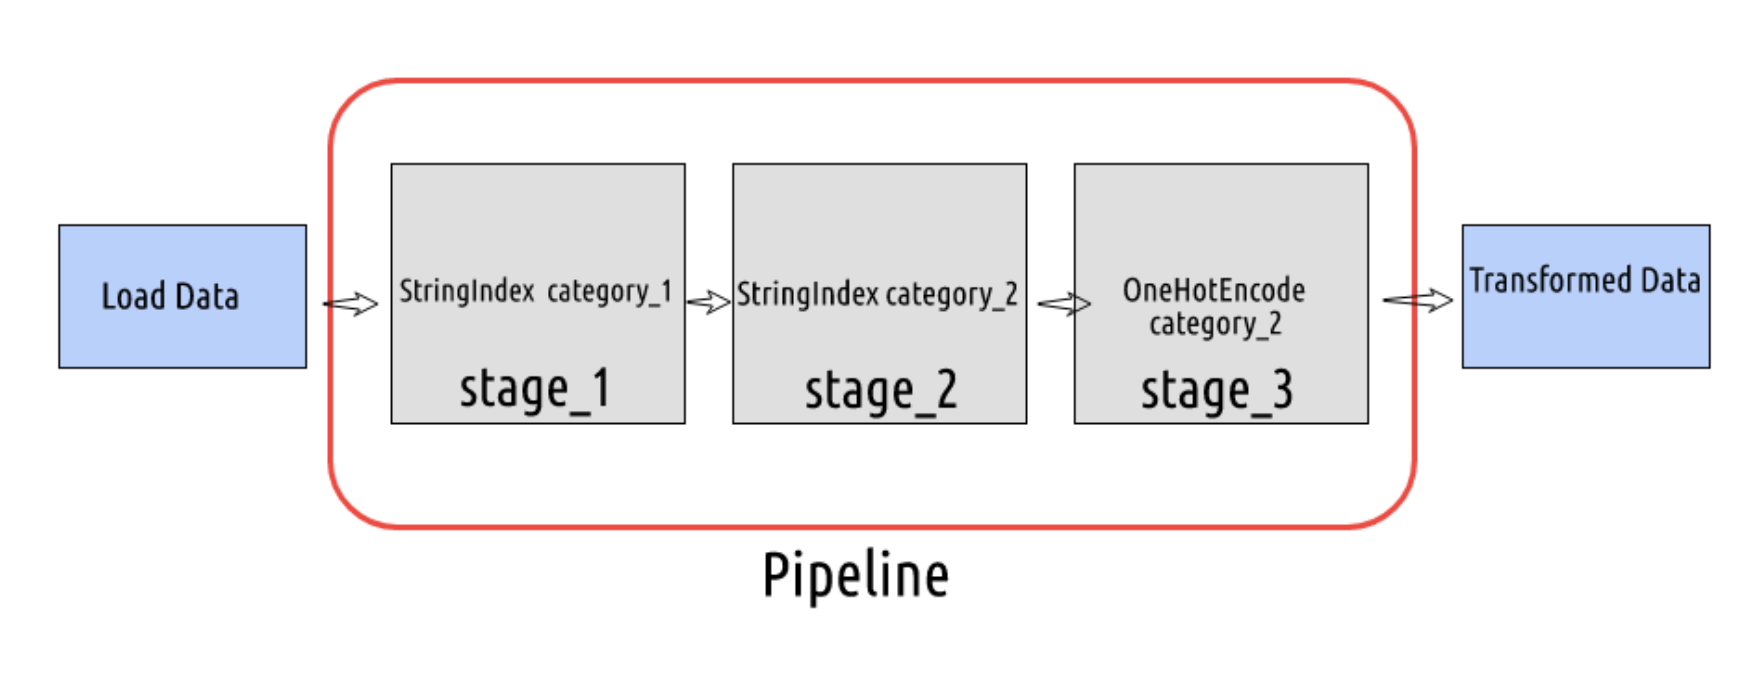

In [38]:
from pyspark.ml import Pipeline

from pyspark.ml.regression import GBTRegressor

stages = []

#depend on categorical columns: country and types of emission

for categoricalCol in str_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol,
                                  outputCol = categoricalCol + '_Index', handleInvalid = 'keep')
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(),
                            outputCol=categoricalCol + "_classVec")
    stages.extend([stringIndexer, encoder])

assemblerInputs = [c + "_classVec" for c in str_cols] + float_cols + int_cols

# transfrom columns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages.append(assembler)

In [39]:
# train/test split (25% test)
trainingData, testData = df_cars.randomSplit([0.75, 0.25])

# Train Gradient Boosting on trees
gbt = GBTRegressor(labelCol=TARGET, featuresCol="features", maxIter=100)
stages.append(gbt)

In [40]:
# build pipline
pipeline = Pipeline(stages=stages)

In [41]:
pipeline.extractParamMap()

{Param(parent='Pipeline_e48a9f83fae4', name='stages', doc='a list of pipeline stages'): [StringIndexer_75028316c10a,
  OneHotEncoder_e8eb8d7d0208,
  StringIndexer_a57dfa328cdb,
  OneHotEncoder_b9bd11cf5b74,
  StringIndexer_55c1d65eef99,
  OneHotEncoder_daed2730b553,
  StringIndexer_3a48b31a8129,
  OneHotEncoder_0c71e099b4ae,
  StringIndexer_bc49f9767605,
  OneHotEncoder_508e6c2109de,
  VectorAssembler_a92153f04556,
  GBTRegressor_82d01005af6f]}

In [42]:
# тренируем модель
model = pipeline.fit(trainingData)

In [43]:
# делаем предсказания на тестовой выборке
predictions = model.transform(testData)

# 7. Validating the model

In [44]:
predictions.select(TARGET, "prediction").show()

+---------------+------------------+
|duration_listed|        prediction|
+---------------+------------------+
|             61|56.655730313094544|
|              4| 7.842711253774789|
|            228| 315.5032535080454|
|             21|32.275357676082386|
|              5| 8.866510680077619|
|            265| 802.4130740066757|
|              8| 8.866510680077619|
|             63| 71.09484842356053|
|            252| 322.3089861038882|
|             90| 89.70395596333664|
|             43| 40.32774543866011|
|             81| 79.01846394233387|
|             92| 89.68249438734743|
|             36| 39.58584747699532|
|            121|122.28051140789209|
|            188|186.34825542857732|
|             25| 26.46774537831986|
|             58| 56.63426873710533|
|            100|107.07030157462191|
|            208|231.91639673468654|
+---------------+------------------+
only showing top 20 rows



In [58]:
gbt_evaluator = RegressionEvaluator(
    labelCol=TARGET, predictionCol="prediction", metricName="r2")
r2 = gbt_evaluator.evaluate(predictions)
print(f"R2 on test data = {r2:.2f}")

R2 on test data = 0.74


# 8. Save model

In [60]:
model.save('model_GBT')

In [45]:
spark.stop()

---